In [ ]:
import legume
import numpy as np

In [4]:
# Number of PhC periods in x and y directions
Nx, Ny = 16, 16

hole_radius, slab_thickness, refractive_index, x_shift = 0.3, 1.081, 2, 0.26

# Get hole positions for L3 cavity
x_pos, y_pos = [], []
nx, ny = Nx//2 + 1, Ny//2 + 1
for iy in range(ny):
    for ix in range(nx):
        if(ix == 0 and iy == 0 or ix == 1 and iy == 0): # skip holes for L3 cavity
            continue
        else:
            x_pos.append(ix + (iy%2)*0.5)
            y_pos.append(iy*np.sqrt(3)/2)
x_pos[0] = x_pos[0] + x_shift

In [2]:
def design_phc(Nx, Ny, x_pos, y_pos, hole_radius, slab_thickness, refractive_index):
    
    # Initialize a lattice and PhC
    lattice = legume.Lattice([Nx, 0], [0, Ny*np.sqrt(3)/2])
    L3_phc = legume.PhotCryst(lattice)

    # Add a layer to the PhC
    L3_phc.add_layer(d=slab_thickness, eps_b=refractive_index**2)
    
    # Get the position of holes for L3 cavity
    nx, ny = Nx//2 + 1, Ny//2 + 1

    # Apply holes symmetrically in the four quadrants
    for ic, x in enumerate(x_pos):
        yc = y_pos[ic] if y_pos[ic] == 0 else y_pos[ic]
        xc = x if x == 0 else x_pos[ic]
        L3_phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=hole_radius))
        if nx-0.6 > x_pos[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > y_pos[ic] > 0:
            L3_phc.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=hole_radius))
        if nx-1.6 > x_pos[ic] > 0:
            L3_phc.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=hole_radius))
        if (ny-1.1)*np.sqrt(3)/2 > y_pos[ic] > 0 and nx-1.1 > x_pos[ic]:
            L3_phc.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=hole_radius))
            
    return L3_phc

In [ ]:
L3_phc = design_phc(Nx, Ny, x_pos, y_pos, hole_radius, slab_thickness,
                                   refractive_index)

# Set some GME options
num_modes = Nx*Ny+2
options = {
    'gmode_inds': [0],
    'verbose': True,
    'numeig': num_modes,
    'compute_im': False,
    'eig_solver': 'eigsh'
    }

# 2x2 grid of k points
nkx, nky = 2, 2
kx = np.linspace(0, (nkx-1)/nkx* 2*np.pi/Nx, nkx)
ky = np.linspace(0, (nky-1)/nky* 2*np.pi/Ny/np.sqrt(3)*2, nky)
kxg, kyg = np.meshgrid(kx, ky)
kxg = kxg.ravel()
kyg = kyg.ravel()
kpoints = np.vstack((kxg, kyg))
    
# Initialize GME
gme = legume.GuidedModeExp(L3_phc, gmax=2.1)

# Solve for the real part of the frequencies
gme.run(kpoints = kpoints, **options)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 3077 plane waves and 1 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'         │ 0.610    │ │--------------------│    2% │
│ Inverse matrix of Fourier-space permittivity                │ 1.681    │ │--------------------│    4% │
│ Matrix diagionalization using the 'eigsh' solver            │ 19.475   │ │█████████-----------│   49% │
│ Creating GME matrix                                         │ 17.725   │ │████████------------│   45% │
├─────────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 4 k-points      │ 39.492   │ │████████████████████│  100% │
└─────────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

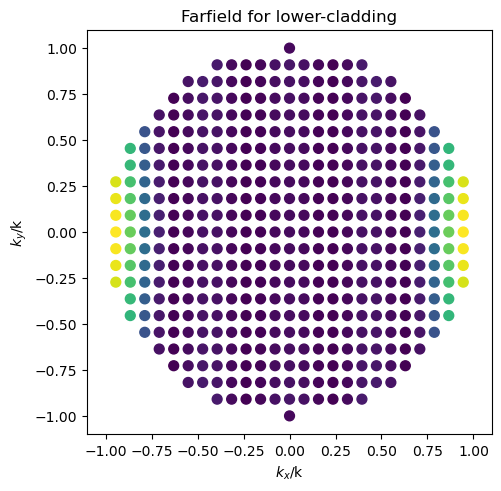

In [ ]:
fig = legume.viz.visualize_far_field(gme, indmode = Nx*Ny, cladding='l')